In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
from GraphTsetlinMachine.graphs import Graphs
import pandas as pd
import argparse
from time import time

Loading data from: IKT457-Learning-System-Final-Project/Data/7x7.csv
Training class distribution: {0: 929, 1: 871}
Testing class distribution: {0: 116, 1: 84}
Initialization of sparse structure.
Epoch 1: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 2: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 3: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 4: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 5: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 6: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 7: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 8: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 9: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 10: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 11: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 12: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 13: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 14: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 15: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 16: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 17: Train Acc: 0.4839, Test Acc: 0.4200
Epoch 18: Train Acc: 0.4839, Tes

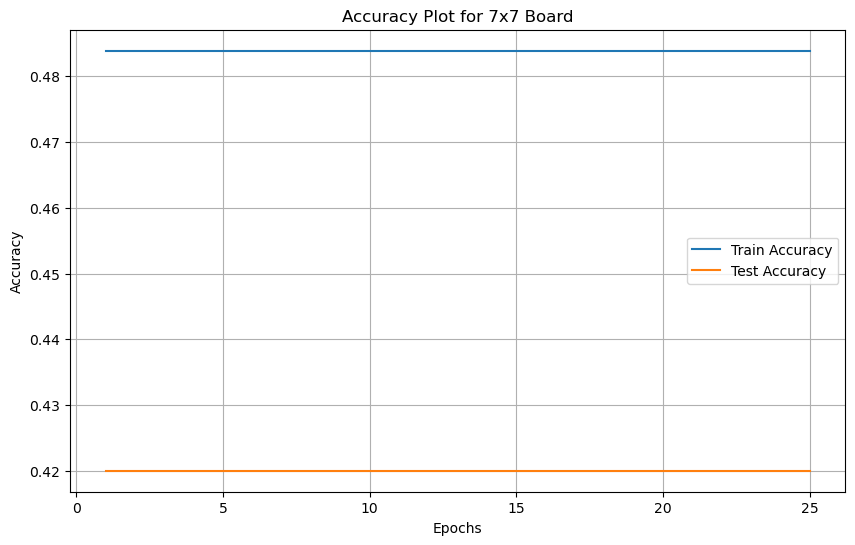

In [2]:
import numpy as np
import pandas as pd
import argparse
from time import time
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
from GraphTsetlinMachine.graphs import Graphs
import matplotlib.pyplot as plt

# Default arguments and parameter initialization
def default_args(**kwargs):
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", default=25, type=int)
    parser.add_argument("--board_size", default=7, type=int)  # Default board size is 5x5
    parser.add_argument("--depth", default=3, type=int)
    parser.add_argument("--hypervector_size", default=32, type=int)
    parser.add_argument("--hypervector_bits", default=2, type=int)
    parser.add_argument("--message_size", default=128, type=int)
    parser.add_argument("--message_bits", default=2, type=int)
    parser.add_argument('--double_hashing', dest='double_hashing', default=False, action='store_true')
    parser.add_argument("--max_included_literals", default=16, type=int)

    args = parser.parse_args(args=[])

    if args.board_size == 5:
        args.number_of_clauses = 20000
        args.T = 10000
        args.s = 100
    elif args.board_size == 6:
        args.number_of_clauses = 20000
        args.T = 5000
        args.s = 5
    elif args.board_size == 7:
        args.number_of_clauses = 7200
        args.T = 1000
        args.s = 1.2
    elif args.board_size == 9:
        args.number_of_clauses = 3200
        args.T = 4000
        args.s = 0.8
    elif args.board_size == 11:
        args.number_of_clauses = 20000
        args.T = 10000
        args.s = 1.0
    elif args.board_size == 13:
        args.number_of_clauses = 5000
        args.T = 8000
        args.s = 0.7

    for key, value in kwargs.items():
        if hasattr(args, key):
            setattr(args, key, value)

    return args

# Load data based on board size
def load_data_for_board_size(board_size):
    file_paths = {
        5: "IKT457-Learning-System-Final-Project/Data/5x5.csv",
        6: "IKT457-Learning-System-Final-Project/Data/6x6.csv",
        7: "IKT457-Learning-System-Final-Project/Data/7x7.csv",
        9: "IKT457-Learning-System-Final-Project/Data/9x9.csv",
        11: "IKT457-Learning-System-Final-Project/Data/11x11.csv",
        13: "IKT457-Learning-System-Final-Project/Data/13x13.csv",
    }
    if board_size not in file_paths:
        raise ValueError(f"Unsupported board size: {board_size}")

    file_path = file_paths[board_size]
    print(f"Loading data from: {file_path}")

    data = pd.read_csv(file_path)
    node_names = [f"{i}_{j}" for i in range(1, board_size + 1) for j in range(1, board_size + 1)]
    
    # Check if all required columns are present
    if not set(node_names + ["Winner"]).issubset(data.columns):
        raise ValueError(f"Missing required columns for board size {board_size}. Check your dataset.")
    
    X = data[node_names].values
    y = data["Winner"].values.astype(int)

    return X, y

# Helper function for node edges
def position_to_edge_id(pos, board_size):
    return pos[0] * board_size + pos[1]

# Initialize arguments
args = default_args()

# Load data
X, y = load_data_for_board_size(args.board_size)

# Ensure labels have variation
if len(np.unique(y)) <= 1:
    raise ValueError("Labels must contain at least two classes for training.")

# Split data into training and testing sets
split_idx = int(len(X) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Check label distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique_train, counts_train))}")
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Testing class distribution: {dict(zip(unique_test, counts_test))}")

# Define edges dynamically based on board size
edges = []
for i in range(args.board_size):
    for j in range(args.board_size):
        if j < args.board_size - 1:
            edges.append(((i, j), (i, j + 1)))
        if i < args.board_size - 1:
            edges.append(((i, j), (i + 1, j)))
        if i < args.board_size - 1 and j > 0:
            edges.append(((i, j), (i + 1, j - 1)))

# Limit edges for nodes dynamically
n_edges_list = []
for i in range(args.board_size ** 2):
    if i == 0 or i == args.board_size ** 2 - 1:
        n_edges_list.append(2)
    elif i == args.board_size - 1 or i == args.board_size ** 2 - args.board_size:
        n_edges_list.append(3)
    elif i // args.board_size == 0 or i // args.board_size == args.board_size - 1:
        n_edges_list.append(4)
    elif i % args.board_size == 0 or i % args.board_size == args.board_size - 1:
        n_edges_list.append(4)
    else:
        n_edges_list.append(6)

# Create training graphs
graphs_train = Graphs(
    number_of_graphs=len(X_train),
    symbols=["O", "X", "."],
    hypervector_size=args.hypervector_size,
    hypervector_bits=args.hypervector_bits,
    double_hashing=args.double_hashing
)

for graph_id in range(X_train.shape[0]):
    graphs_train.set_number_of_graph_nodes(graph_id, args.board_size ** 2)

graphs_train.prepare_node_configuration()

# Add nodes and properties to each graph
for graph_id, board in enumerate(X_train):
    for node_id in range(len(board)):
        graphs_train.add_graph_node(graph_id, f"node_{node_id}", n_edges_list[node_id])
        graphs_train.add_graph_node_property(graph_id, f"node_{node_id}", board[node_id])

graphs_train.prepare_edge_configuration()

# Add edges
def add_edges(graphs, edges):
    for graph_id in range(graphs.number_of_graphs):
        for edge in edges:
            src_id = position_to_edge_id(edge[0], args.board_size)
            dest_id = position_to_edge_id(edge[1], args.board_size)
            graphs.add_graph_node_edge(graph_id, f"node_{src_id}", f"node_{dest_id}", edge_type_name="Plain")
            graphs.add_graph_node_edge(graph_id, f"node_{dest_id}", f"node_{src_id}", edge_type_name="Plain")

add_edges(graphs_train, edges)
graphs_train.encode()

# Create testing graphs
graphs_test = Graphs(len(X_test), init_with=graphs_train)

for graph_id in range(X_test.shape[0]):
    graphs_test.set_number_of_graph_nodes(graph_id, args.board_size ** 2)

graphs_test.prepare_node_configuration()

for graph_id, board in enumerate(X_test):
    for node_id in range(len(board)):
        graphs_test.add_graph_node(graph_id, f"node_{node_id}", n_edges_list[node_id])
        graphs_test.add_graph_node_property(graph_id, f"node_{node_id}", board[node_id])

graphs_test.prepare_edge_configuration()
add_edges(graphs_test, edges)
graphs_test.encode()

# Train and evaluate the GTM
tm = MultiClassGraphTsetlinMachine(
    args.number_of_clauses,
    args.T,
    args.s,
    depth=args.depth,
    message_size=args.message_size,
    message_bits=args.message_bits,
    max_included_literals=args.max_included_literals
)

train_accuracies = []
test_accuracies = []

start_training = time()
for epoch in range(args.epochs):
    tm.fit(graphs_train, y_train, epochs=1, incremental=True)
    train_acc = np.mean(y_train == tm.predict(graphs_train))
    test_acc = np.mean(y_test == tm.predict(graphs_test))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch + 1}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

print(f"Training time: {time() - start_training:.2f} seconds")

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, args.epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, args.epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Plot for {args.board_size}x{args.board_size} Board')
plt.legend()
plt.grid(True)
plt.show()
